# Analyze the BIOFAB's data from the protein-stability assay on the *third* chip from the topology-mining project

## Import `Python` modules

In [1]:
import os
import sys
sys.path.append('scripts/')
import prot_stab_utils
import re
import glob

import xml.etree.ElementTree as ET
sys.path.append("/home/jupyter/tacc-work/jupyter_packages/lib/python2.7/site-packages")
from FlowCytometryTools import *

import numpy as np
import math
import scipy.stats
import pandas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("ticks")
from IPython.display import Image

# Initialize directories
resultsdir = "results/180702_topology_mining_chip_4"
resultsdir_parse_metadata = os.path.join(resultsdir, 'parse_metadata')
dirs = [resultsdir, resultsdir_parse_metadata]
for dir_i in dirs:
    if not os.path.isdir(dir_i):
        os.makedirs(dir_i)

## Make the input experimental-summary file

### Specify all inputs

In [2]:
# Specify the name of the library
library_name = 'protein design downselect 4 with ladder 1'

# Specify the output metadata CSV file
experimental_metadata_output_file = os.path.join(resultsdir_parse_metadata, 'experimental_metadata_from_script.csv')

# Specify the location of FASTQ files
data_dir = '/work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/protein_design_data/Plan_19977'
summary_file = os.path.join(data_dir, 'manifest.csv')
fastq_dir = os.path.join(data_dir, 'ngs_data/')

# Specify the location of FACS data
facs_dir = os.path.join(data_dir, 'facs_data/')

# Define FACS metadata
map_job_id_to_sort_round = {
    'Job_75079' : 1, 'Job_75591' : 2, 'Job_76231' : 3
}
sort_rounds_with_identical_control = [1]

# Read in sample metadata
summary_df = pandas.read_csv(summary_file)

# For each sample, specify a unique file prefix that will be used to find FASTQ files for that sample
summary_df['aq_item_id'] = summary_df['aq_item_id'].fillna(0).astype(int)
summary_df['fastq_id'] = summary_df['aq_item_id'].apply(
    lambda x: os.path.join(str(x), 'Files/')
)

# For each sample, specify a unique file prefix that will be used to find FACS files for that sample
summary_df.rename(columns={'sort_job':'job_id'}, inplace=True)
summary_df['facs_file_prefix'] = summary_df.apply(
    lambda row: os.path.join(facs_dir, str(row['job_id']), str(row['facs_filename_stub'])), axis=1
)

# Make other changes to the dataframe
summary_df['protease'] = summary_df['protease'].apply(lambda x: x.lower())
summary_df.set_index(['protease', 'concentration'], inplace=True)
summary_df.sort_index(inplace=True)
summary_df = summary_df[
    summary_df['strain'] == library_name
]
summary_df

aq_item_id  \
protease     concentration               
chymotrypsin 0.0                150282   
             0.0                151146   
             28.0               152806   
             83.0               152807   
             250.0              152810   
             750.0              152811   
             2250.0             152814   
             6750.0             152815   
naive        NaN                152804   
trypsin      0.0                152805   
             0.0                150285   
             0.0                151149   
             9.5                152808   
             28.0               152809   
             83.0               152812   
             250.0              152813   
             750.0              152816   
             2250.0             152817   

                                                               strain  \
protease     concentration                                              
chymotrypsin 0.0            protein design downselect 4 with ladder 1   
             0.0            protein design downselect 4 with ladder 1   
             28.0           protein design downselect 4 with ladder 1   
             83.0           protein design downselect 4 with ladder 1   
             250.0          protein design downselect 4 with ladder 1   
             750.0          protein design downselect 4 with ladder 1   
             2250.0         protein design downselect 4 with ladder 1   
             6750.0         protein design downselect 4 with ladder 1   
naive        NaN            protein design downselect 4 with ladder 1   
trypsin      0.0            protein design downselect 4 with ladder 1   
             0.0            protein design downselect 4 with ladder 1   
             0.0            protein design downselect 4 with ladder 1   
             9.5            protein design downselect 4 with ladder 1   
             28.0           protein design downselect 4 with ladder 1   
             83.0           protein design downselect 4 with ladder 1   
             250.0          protein design downselect 4 with ladder 1   
             750.0          protein design downselect 4 with ladder 1   
             2250.0         protein design downselect 4 with ladder 1   

                               job_id     facs_filename_stub  frac_positive  \
protease     concentration                                                    
chymotrypsin 0.0            Job_75591  Specimen_001_Tube_005            NaN   
             0.0            Job_76231  Specimen_001_Tube_006            NaN   
             28.0           Job_75079  Specimen_001_Tube_007          0.274   
             83.0           Job_75079  Specimen_001_Tube_008          0.227   
             250.0          Job_75591  Specimen_001_Tube_008          0.459   
             750.0          Job_75591  Specimen_001_Tube_009          0.234   
             2250.0         Job_76231  Specimen_001_Tube_008          0.212   
             6750.0         Job_76231  Specimen_001_Tube_009          0.077   
naive        NaN                  NaN                    NaN            NaN   
trypsin      0.0            Job_75079  Specimen_001_Tube_006          0.310   
             0.0            Job_75591  Specimen_001_Tube_006            NaN   
             0.0            Job_76231  Specimen_001_Tube_007            NaN   
             9.5            Job_75079  Specimen_001_Tube_009          0.246   
             28.0           Job_75079  Specimen_001_Tube_010          0.225   
             83.0           Job_75591  Specimen_001_Tube_010          0.338   
             250.0          Job_75591  Specimen_001_Tube_011          0.170   
             750.0          Job_76231  Specimen_001_Tube_010          0.232   
             2250.0         Job_76231  Specimen_001_Tube_011          0.037   

                                 fastq_id  \
protease     concentration                  
chymotrypsin 0.0            150282/Files/   
          

### Analyze the FACS data, recording relevant information for each sample such as the fraction of cells passing the FITC cutoff for both the sample and untreated controls, as well as the total number of cells collected for each sample

In [3]:
def find_facs_file(facs_file_prefix):
    """Find all files with a given prefix"""
    
    # Find all files with given prefix, make sure there
    # is only one matching file, and return its path
    facs_files = glob.glob(facs_file_prefix + '*.fcs')
    if len(facs_files) == 1:
        return facs_files[0]
    elif len(facs_files) == 0:
        return None
    
def s_log(sample, channel_names):
    """Transform FACS data to log10 space"""
    
    # Copy dataframe and get relevant FACS data
    new_sample = sample.copy()
    new_data = new_sample.data

    # Transform the FACS data to log10 space
    for channel_name in channel_names:
        new_data[channel_name] = np.log10(new_data[channel_name])
    
    # Replace values of negative infinity with negative one, remove
    # entries with `nan` values, and return a dataframe with the
    # final values
    new_data.replace(to_replace = -np.inf, value = -1, inplace = True)
    new_data = new_data.dropna()
    new_sample.data = new_data
    
    return new_sample

def compute_fraction_collected(fcs_file, sorting_threshold=3.0):
    """Compute the fraction of cells that passed the FITC gate during sorting"""
    
    # Return `None` if the file doesn't exist
    if not isinstance(fcs_file, str):
        return None
    elif not os.path.isfile(fcs_file):
        return None
    
    # Get FACS data from a given file and for a given chanel
    else:
        sample = FCMeasurement(ID='Test Sample', datafile=fcs_file)
        sample = s_log(sample, [facs_channel_name])
        df = sample.data

        # Count the number of total events and events passing the gate
        total_number_of_recorded_events = float(len(df.index.values))
        number_of_events_passing_fitc_gate = sum(df[facs_channel_name] > sorting_threshold)
        fraction_collected = number_of_events_passing_fitc_gate / total_number_of_recorded_events
        #return (pandas.Series([total_number_of_recorded_events, number_of_events_passing_fitc_gate, fraction_collected]))
        return fraction_collected

First, compute the fraction of cells that were collected for each sample

In [4]:
# Search for the FACS file associated with each sample
summary_df['facs_file_name'] = summary_df['facs_file_prefix'].apply(
    lambda x: find_facs_file(x)
)

# Specify the FACS channel name to investigate
facs_channel_name = u'FITC-A'

# Compute the faction of cells that passed the FITC gate for each sample
summary_df['fraction_collected'] = summary_df.apply(
    lambda row: compute_fraction_collected(row['facs_file_name']), axis=1
)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


Plot the distribution of FITC values for each sample with this type of data, as well as the sorting threshold used to select cells

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


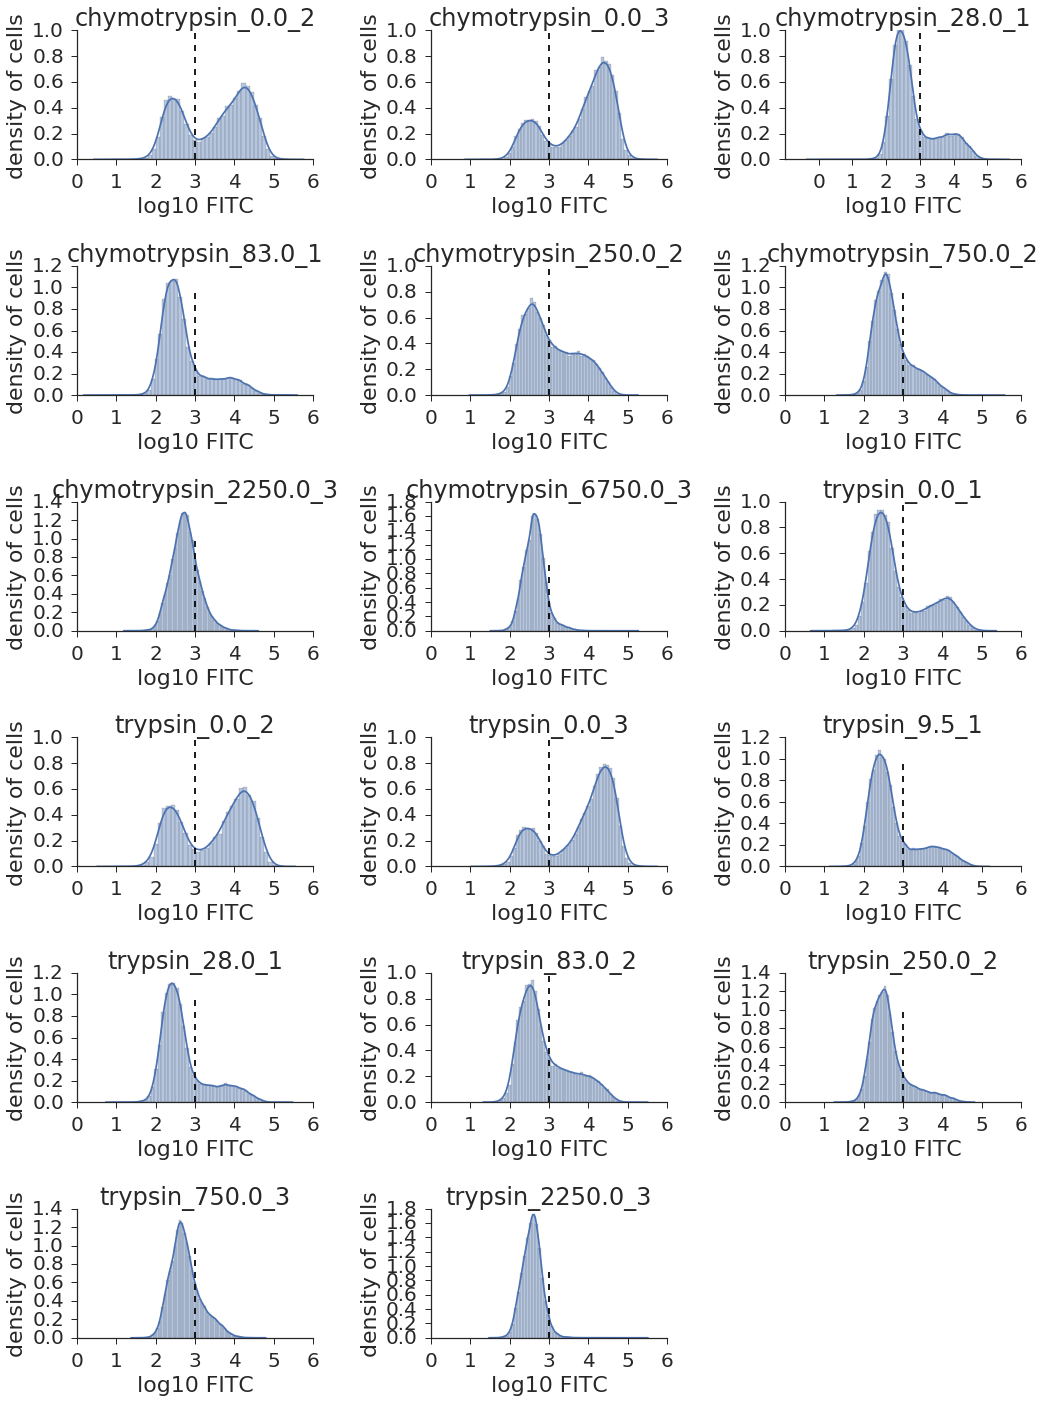

In [5]:
# Make a dataframe with only samples that have FACS data
# and then initiate a figure with subplots
data = summary_df[~summary_df['facs_file_name'].isnull()].copy()
nplots = len(data)
ncols = 3
nrows = int(math.ceil(nplots/float(ncols)))
xticks = list(range(0,7))
fig = plt.figure(figsize=[15,20])

# Plot the FACS data, showing the sorting threshold in each
# case
sorting_threshold = 3.0
for (plot_n, (i, row)) in enumerate(data.iterrows(), 1):

    # Get metadata and read in FACS data
    (protease_type, concentration) = i
    fcs_file = row['facs_file_name']
    selection_round = map_job_id_to_sort_round[row['job_id']]
    sample = FCMeasurement(ID='Test Sample', datafile=fcs_file)
    sample = s_log(sample, [facs_channel_name])
    df = sample.data
    
    # Plot the FACS data
    ax = fig.add_subplot(nrows, ncols, plot_n)
    sns.distplot(df[facs_channel_name], ax=ax)
    sns.despine()
    ax.set_title('{0}_{1}_{2}'.format(protease_type, concentration, selection_round))
    ax.set_xlabel('log10 FITC')
    ax.set_ylabel('density of cells')
    ax.plot([sorting_threshold, sorting_threshold], [0, 1.0], c='k', ls='--')
axs = fig.get_axes()
plt.setp(axs, xticks=xticks)
plt.tight_layout()
plt.show()

Compute `parent_expression` values. For each sample, this value gives the fraction of cells passing the FITC cutoff in a protease-naive untreated control sample, setting a baseline for how many cells would be expected to pass in the absence of protease. After computing these values, I will remove the naive samples used to compute these values as they are not used in further analysis.

In [6]:
# Make a dictionary that gives `parent_expression` values for each sorting round
print("The following rounds have identical naive controls: {0}".format(
    ', '.join(map(str, sort_rounds_with_identical_control))
))
naive_sample_expression = {'trypsin':{}, 'chymotrypsin':{}}
list_of_indices_to_drop = []

for (i, row) in summary_df.iterrows():
    (protease, concentration) = i
    if math.isnan(concentration):
        continue
    sort_round = map_job_id_to_sort_round[row['job_id']]
    if concentration == 0.0:
        assert (sort_round not in naive_sample_expression[protease].keys()), "Found multiple controls for same round"
        
        # If a single control is used for both proteases, record an identical value
        # for both proteases. Otherwise, record protease-specific values
        if sort_round in sort_rounds_with_identical_control:
            for protease_i in naive_sample_expression.keys():
                naive_sample_expression[protease_i][sort_round] = row['fraction_collected']
        else:
            naive_sample_expression[protease][sort_round] = row['fraction_collected']
        list_of_indices_to_drop.append(i)
        
# Remove protease naive samples that will not be used in downstream steps
summary_df.drop(list_of_indices_to_drop, axis='index', inplace=True)
summary_df.reset_index(inplace=True)

# Add the `parent_expression` column
def record_parent_expression(protease, job_id):
    if job_id not in map_job_id_to_sort_round:
        return None
    else:
        sort_round = map_job_id_to_sort_round[job_id]
        if sort_round in naive_sample_expression[protease].keys():
            return naive_sample_expression[protease][sort_round]
        else:
            return None
        
summary_df['parent_expression'] = summary_df.apply(
    lambda row: record_parent_expression(row['protease'], row['job_id']), axis=1
)

The following rounds have identical naive controls: 1


Next, I will determine the total number of cells collected for each sample. These data are encoded in separate files than the ones analyzed above. In these files, the data are organized by specimen and tube numbers. These numbers are also present in the above dataframe in the column called `facs_filename_stub`. I will parse these values and then use them to match the new FACS data with the appropriate samples in the dataframe.

In [7]:
def parse_specimen_and_tube(spec_and_tube_string):
    """Parse the specimen and tube numbers from an input string with an expected pattern"""
    
    # Define the expected pattern
    spec_and_tube_pattern = re.compile(r'(?P<spec>Specimen_\d+)_(?P<tube>Tube_\d+)')
    
    # Return `None` if the input variable isn't a string or does not
    # contain the expected pattern. Otherwise, return the parsed values
    if not isinstance(spec_and_tube_string, str):
        return(pandas.Series([None, None]))
    else:
        match = re.search(spec_and_tube_pattern, spec_and_tube_string)
        if match:
            return(pandas.Series([match.group('spec'), match.group('tube')]))
        else:
            return(pandas.Series([None, None]))

summary_df[['specimen', 'tube']] = summary_df.apply(
    lambda row: parse_specimen_and_tube(row['facs_filename_stub']), axis=1
)

summary_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)
summary_df.sort_index(inplace=True)

Read in data from the XML files on the total number of cells collected. I will do this for all XML files the BIOFAB has uploaded, even ones that aren't relevant to this experiment. Then, I will identify the relevant ones using the `job_id`, `specimen`, and `tube` columns.

In [8]:
# Compile data in each XML file
xml_data_dict = {
    key : []
    for key in ['job_id', 'specimen', 'tube', 'cells_collected', 'intended_number_of_cells_collected'] #
}
cells_collected_pattern = re.compile(r'\w+ : (?P<cells_collected>\d+) / (?P<intended_number_of_cells_collected>\d+)')
xml_files = glob.glob(os.path.join(facs_dir, '*/*/*.xml'))
for filename in xml_files:
    tree = ET.parse(filename)
    root = tree.getroot()

    # Get experiment metadata
    xml_data_dict['job_id'].append( root.findall(".//*[@name='Experiment']")[0].get('value') )
    xml_data_dict['specimen'].append( root.findall(".//*[@name='Specimen']")[0].get('value') )
    xml_data_dict['tube'].append( root.findall(".//*[@name='Tube']")[0].get('value') )
    xml_data_dict['xmlfile'] = filename
    
    # Get experiment counts
    cells_collected_data = root[4].findall(".//*[@col='1']")[0].text
    match = re.match(cells_collected_pattern, cells_collected_data)
    if match:
        xml_data_dict['cells_collected'].append(
            int(match.group('cells_collected'))
        )
        xml_data_dict['intended_number_of_cells_collected'].append(
            int(match.group('intended_number_of_cells_collected'))
        )
    else:
        xml_data_dict['cells_collected'].append(None)
        xml_data_dict['intended_number_of_cells_collected'].append(None)
          
# Convert data to a dataframe
xml_data_df = pandas.DataFrame.from_dict(xml_data_dict)
xml_data_df.set_index(['job_id', 'specimen', 'tube'], inplace=True)

# Check for entries with duplicate indices and remove the one with the
# fewest counts if multiple exist
if sum(xml_data_df.index.duplicated()) > 0:
    print("Found duplicate indices. Will keep the duplicate with the highest counts, removing the rest")
    xml_data_df.sort_values(by='cells_collected', ascending=False, inplace=True)
    xml_data_df = xml_data_df[~xml_data_df.index.duplicated()]

Found duplicate indices. Will keep the duplicate with the highest counts, removing the rest


Merge the FACS data from the two input sources

In [9]:
# Merge the two sources of FACS data
summary_df = summary_df.merge(
    xml_data_df[['cells_collected', 'intended_number_of_cells_collected']],
    left_index=True, right_index=True, how='left'
)

### Tweak the names of certain entries and manually add missing columns

Change the entry for the protease-naive unsorted sample to have the `protease` column equal `trypsin` and the `concentration` column to equal `0.0`, which is consistent with the naming scheme used in Rocklin et al., 2017, Science.

In [10]:
# Add a row for a naive sample for each protease
trypsin_naive_df = summary_df[
    summary_df['protease'] == 'naive'
].replace('naive', 'trypsin')

chymotrypsin_naive_df = summary_df[
    summary_df['protease'] == 'naive'
].replace('naive', 'chymotrypsin')
summary_df = pandas.concat([summary_df, trypsin_naive_df, chymotrypsin_naive_df])

# Convert the concentration of the naive samples to `0.0`, drop the row with `naive`
# in the `protease` column, then sort by protease and concentration
summary_df['concentration'].replace(np.nan, 0.0, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.set_index(['protease', 'concentration'], inplace=True)
summary_df.drop(('naive', 0.0), inplace=True)
summary_df.sort_index(inplace=True)

Manually add missing columns

In [11]:
summary_df['experiment_id'] = library_name
summary_df['selection_strength'] = 2 * [i for i in range(0,7)]
summary_df['conc_factor'] = 2 * ['', '3', '3', '3', '3', '3', '3']
summary_df['parent'] = 2 * ['', '0', '0', '2', '2', '4', '4']

Rename columns and show the final dataframe.

In [12]:
# Rename columns
summary_df.reset_index(inplace=True)
summary_df.rename(
    {'protease':'protease_type'},
    inplace=True,
    axis='columns'
)
column_order = [
    'experiment_id', 'protease_type', 'concentration', 'selection_strength', 'parent', 'conc_factor', 'fastq_id',
    'parent_expression', 'fraction_collected', 'cells_collected'
]
summary_df[column_order]

,experiment_id,protease_type,concentration,selection_strength,parent,conc_factor,fastq_id,parent_expression,fraction_collected,cells_collected
0,protein design downselect 4 with ladder 1,chymotrypsin,0.0,0,,,152804/Files/,NaN,NaN,NaN
1,protein design downselect 4 with ladder 1,chymotrypsin,28.0,1,0,3,152806/Files/,0.309233,0.273633,3287999.0
2,protein design downselect 4 with ladder 1,chymotrypsin,83.0,2,0,3,152807/Files/,0.309233,0.226400,2723999.0
3,protein design downselect 4 with ladder 1,chymotrypsin,250.0,3,2,3,152810/Files/,0.641388,0.456433,5508000.0
4,protein design downselect 4 with ladder 1,chymotrypsin,750.0,4,2,3,152811/Files/,0.641388,0.231767,2808000.0
5,protein design downselect 4 with ladder 1,chymotrypsin,2250.0,5,4,3,152814/Files/,0.769033,0.207300,2544000.0
6,protein design downselect 4 with ladder 1,chymotrypsin,6750.0,6,4,3,152815/Files/,0.769033,0.075000,924000.0
7,protein design downselect 4 with ladder 1,trypsin,0.0,0,,,152804/Files/,NaN,NaN,NaN
8,protein design downselect 4 with ladder 1,trypsin,9.5,1,0,3,152808/Files/,0.309233,0.244700,2952000.0
9,protein design downselect 4 with ladder 1,trypsin,28.0,2,0,3,152809/Files/,0.309233,0.223300,2700000.0


Write the above dataframe to an output file

In [13]:
print("Writing metadata to the experimental summary file: {0}".format(experimental_metadata_output_file))
summary_df[column_order].to_csv(experimental_metadata_output_file, index=False)

Writing metadata to the experimental summary file: results/180702_topology_mining_chip_4/parse_metadata/experimental_metadata_from_script.csv


## Make a file with all input sequences in the library, including ladder sequences both with and without `GSS` padding

All designs on the chip were padded with `GSS` pads, except for the ladder sequences, which were not. However, we also spiked in a library of the ladder with `GSS` pads. To make a file with all of these starting sequences, I will first read in `GSS`-padded versions of all sequences. I will then read in non-padded versions of the ladder sequences, adding the suffix `_no_padding` to the end of each name. Finally, I will concatenate these lists, removing ladder sequences that are duplicated between the two sets (this can happen if a sequence does not require padding because it is already the length that all sequences are normalized to be), removing the second duplicate of each. Since the sequences with suffix `_no_padding` always come second, this set of sequences will not include the full ladder.

In [14]:
# Read in sequences with `GSS` padding
sequences_df = pandas.read_csv('data/180702_topology_mining/chip4_padded_protein_sequences.csv')
sequences_df.rename(columns={'padded_sequence':'protein_sequence'}, inplace=True)

# Read in ladder sequences without `GSS` padding, adding the suffix `_no_padding`,
# at the end of each name
ladder_df = pandas.read_csv('data/180702_topology_mining/ladder_sequences.csv')
ladder_df['name'] = ladder_df['chip_name'].apply(lambda x: x + '_no_padding')
ladder_df.rename(columns={'sequence':'protein_sequence'}, inplace=True)

# Merge the sequences together, then remove duplicates, keeping the first.
# Then write these sequences to an output file
df = pandas.concat([sequences_df, ladder_df[['name', 'protein_sequence']]])
n_duplicates = sum(df.duplicated(subset='protein_sequence'))
print("Found {0} duplicated sequences. Will keep the first and remove the rest.".format(n_duplicates))
df.drop_duplicates(subset='protein_sequence', keep='first', inplace=True)
designed_sequences_output_file = os.path.join(resultsdir, 'designed_sequences.csv')
print("Writing all input sequences to the file: {0}".format(designed_sequences_output_file))
df.to_csv(designed_sequences_output_file, index=False)

Found 25 duplicated sequences. Will keep the first and remove the rest.
Writing all input sequences to the file: results/180702_topology_mining_chip_4/designed_sequences.csv


## Compute EC50 values from the input deep-sequencing and FACS data using the script `compute_ec50_values_from_deep_sequencing_data.py`

In the below cell, I define input variables and then assemble and print a command-line argument for running the script `compute_ec50_values_from_deep_sequencing_data.py`.

To actually run this script requires activating the `Conda` environment specified by the file called `environment_compute_ec50_values.yml` and then executing the arguement, which I will do manually.

In [15]:
# Define input variables
designed_sequences_file = designed_sequences_output_file
experimental_summary_file = experimental_metadata_output_file
fastq_dir = fastq_dir
pear_path = '/home/05402/haddox/software/pear/bin/pear'
five_prime_flanking_seq = 'CATATG'
three_prime_flanking_seq = 'CTCGAG'
output_dir = resultsdir

# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/compute_ec50_values_from_deep_sequencing_data.py',
    '--designed_sequences_file {0}'.format(designed_sequences_file),
    '--experimental_summary_file {0}'.format(experimental_summary_file),
    '--fastq_dir {0}'.format(fastq_dir),
    '--pear_path {0}'.format(pear_path),
    '--five_prime_flanking_seq {0}'.format(five_prime_flanking_seq),
    '--three_prime_flanking_seq {0}'.format(three_prime_flanking_seq),
    '--output_dir {0}'.format(output_dir)
])
print("To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml:\n")
print('source activate 2018_prot_stab_compute_ec50_values')
print("\nThen run the command:\n")
print(cmd)

To complete this step, manually activate the environment encoded in environment_compute_ec50_values.yml:

source activate 2018_prot_stab_compute_ec50_values

Then run the command:

python scripts/compute_ec50_values_from_deep_sequencing_data.py --designed_sequences_file results/180702_topology_mining_chip_4/designed_sequences.csv --experimental_summary_file results/180702_topology_mining_chip_4/parse_metadata/experimental_metadata_from_script.csv --fastq_dir /work/05402/haddox/jupyter/sd2e-community/shared-q1-workshop/strcklnd/protein_design_data/Plan_19977/ngs_data/ --pear_path /home/05402/haddox/software/pear/bin/pear --five_prime_flanking_seq CATATG --three_prime_flanking_seq CTCGAG --output_dir results/180702_topology_mining_chip_4


## Next, compute stability scores from EC50 values using the script `compute_stability_scores_from_EC50_values.py`

In the below cell, I define input variables and then assemble and print a command-line argument for running the script `compute_stability_scores_from_EC50_values.py`.

To actually run this script requires activating the `Conda` environment specified by the file called `environment_compute_stability_scores.yml` and then executing the below arguements, which I will do manually.

In [16]:
# Define input variables
proteases = ['trypsin', 'chymotrypsin']
conc_factor = '3'
stability_output_dir = os.path.join(output_dir, 'stability_scores/')

# Put together the command
print("To complete this step, manually activate the environment encoded in environment_compute_stability_scores.yml\n")
print('source activate 2018_prot_stab_compute_stability_scores')
print("\nThen run the commands:\n")
for protease in proteases:

    # Define the names of the input file with EC50 values and the output file
    # that will have the computed stability scores
    ec50_values_file = os.path.join(output_dir, 'ec50_values/{0}.fulloutput'.format(protease))
    output_file = os.path.join(stability_output_dir, '{0}_stability_scores.txt'.format(protease))

    # Define and print the command
    cmd = ' '.join([
        'python',
        'scripts/compute_stability_scores_from_EC50_values.py',
        designed_sequences_file,
        protease,
        ec50_values_file,
        conc_factor,
        output_file
    ])

    print(cmd)
    print('\n')

To complete this step, manually activate the environment encoded in environment_compute_stability_scores.yml

source activate 2018_prot_stab_compute_stability_scores

Then run the commands:

python scripts/compute_stability_scores_from_EC50_values.py results/180702_topology_mining_chip_4/designed_sequences.csv trypsin results/180702_topology_mining_chip_4/ec50_values/trypsin.fulloutput 3 results/180702_topology_mining_chip_4/stability_scores/trypsin_stability_scores.txt


python scripts/compute_stability_scores_from_EC50_values.py results/180702_topology_mining_chip_4/designed_sequences.csv chymotrypsin results/180702_topology_mining_chip_4/ec50_values/chymotrypsin.fulloutput 3 results/180702_topology_mining_chip_4/stability_scores/chymotrypsin_stability_scores.txt




Merge stability scores between proteases, computing the minimum stability scores for the two proteases, and creating a file with a single dataframe with data from each protease, with suffixes of `_t` or `_c` indicating that the data is derived from trypsin or chymotrypsin, respectively, and a new column called `stabilityscore` that gives the minimum stability score between the two proteases.

In [17]:
stability_scores_trypsin_file = os.path.join(stability_output_dir, 'trypsin_stability_scores.txt')
stability_scores_chymotrypsin_file = os.path.join(stability_output_dir, 'chymotrypsin_stability_scores.txt')
merged_stability_scores_outfile = os.path.join(stability_output_dir, 'stability_scores.txt')
print("Writing merged stability scores to the file: {0}".format(merged_stability_scores_outfile))
prot_stab_utils.merge_stability_scores_between_proteases(
    stability_scores_trypsin_file,
    stability_scores_chymotrypsin_file,
    merged_stability_scores_outfile
)

Writing merged stability scores to the file: results/180702_topology_mining_chip_4/stability_scores/stability_scores.txt


Make an indexed version of the data

In [18]:
# Read in the stability scores
stability_scores_df = pandas.read_csv(merged_stability_scores_outfile, sep='\t')
stability_scores_df.rename(columns={'name':'chip_name'}, inplace=True)
stability_scores_df.set_index('chip_name', inplace=True)

# Read in a dataframe for converting names from the chip order
# to original names of PDB files
naming_df = pandas.read_csv('data/180702_topology_mining/naming_key.csv')
naming_df.set_index('chip_name', inplace=True)

# Merge the original names with the dataframe of stability scores
stability_scores_for_sd2_df = stability_scores_df.merge(naming_df, left_index=True, right_index=True, how='left')
stability_scores_for_sd2_df = stability_scores_for_sd2_df[
    ~stability_scores_for_sd2_df['name'].isnull() &
    ~stability_scores_for_sd2_df['stabilityscore'].isnull()
]
stability_scores_for_sd2_df.reset_index(inplace=True)
stability_scores_for_sd2_df.set_index('name', inplace=True)

# Make sure the original sequence is in the sequence on the chip, the latter of which
# has GSS padding
stability_scores_for_sd2_df['original_sequence_in_chip_sequence'] = stability_scores_for_sd2_df.apply(
    lambda row: row['sequence'] in row['protein_sequence_c'], axis=1
)
assert sum(~stability_scores_for_sd2_df['original_sequence_in_chip_sequence']) == 0


# Read in the index file for this chip
index_file = 'data/180702_topology_mining/topology_mining_and_Longxing_chip_4.index.csv'
index_df = pandas.read_csv(
    index_file,
    comment='#'
)
index_df.set_index('name', inplace=True)

# Merge the index and the stability scores
df = index_df.merge(
    stability_scores_for_sd2_df,
    left_index=True,
    right_index=True,
    how='left'
)
library_name = set(df['library'])
assert len(library_name) == 1
library_name = list(library_name)[0]
df.reset_index(inplace=True)
df.set_index(['library', 'name'], inplace=True)
indexed_stability_scores_outfile = os.path.join(
    resultsdir,
    'stability_scores',
    '{0}.experimental_stability_scores.csv'.format(library_name)
)
print("Writing an indexed version of the stability scores to the file: {0}".format(indexed_stability_scores_outfile))
with open(indexed_stability_scores_outfile, 'w') as f:
    f.write('# Author: Hugh Haddox\n')
    f.write('# Index: {0}\n'.format(os.path.basename(index_file)))
    df.to_csv(f)

Writing an indexed version of the stability scores to the file: results/180702_topology_mining_chip_4/stability_scores/topology_mining_and_Longxing_chip_4.experimental_stability_scores.csv


Make an indexed version of the data for the ladder sequences

In [19]:
# Make a dataframe of stability scores for just ladder sequences
stability_scores_df['ladder'] = stability_scores_df.apply(lambda row: 'ladder' in row.name, axis=1)
ladder_stability_scores_df = stability_scores_df[
    (stability_scores_df['ladder'])
].copy()

# Only analyze the unpadded sequences since these have much higher counts. This includes
# 65 amino-acid proteins in the ladder that do not have `no_padding` in their name since
# padding wasn't necessary to begin with. I will include this latter set of sequences
# further down when I see which ones are missing if I only analyze sequences with `no_padding`
# in the name
ladder_stability_scores_df['no_padding'] = ladder_stability_scores_df.apply(
    lambda row: 'no_padding' in row.name, axis=1
)
no_padding_ladder_stability_scores_df = ladder_stability_scores_df[
    (ladder_stability_scores_df['no_padding'])
].copy()
no_padding_ladder_stability_scores_df.reset_index(inplace=True)
no_padding_ladder_stability_scores_df['chip_name'] = no_padding_ladder_stability_scores_df['chip_name'].apply(
    lambda x: x.replace('_no_padding', '')
)
no_padding_ladder_stability_scores_df.set_index('chip_name', inplace=True)

# Read in a dataframe that contains ladder indices and original chip names and then
# merge the two dataframes
ladder_index_df = pandas.read_csv('data/180702_topology_mining/ladder_1.ladder_ec50_values.csv', comment='#')
ladder_index_df.set_index('chip_name', inplace=True)

# Identify sequences that are missing in the `no_padded` group due to length or other reasons, then
# add these to the dataframe of ladder stability scores from the remaining ladder sequences not in
# the `no_padded` group
missing_ladder_names = list(set(ladder_index_df.index.values).difference(
    set(no_padding_ladder_stability_scores_df.index.values)
))
all_ladder_stability_scores = pandas.concat([
    no_padding_ladder_stability_scores_df,
    ladder_stability_scores_df.loc[missing_ladder_names]
])

# Merge the scores for all ladder sequences with the index dataframe
all_ladder_stability_scores = all_ladder_stability_scores.merge(
    ladder_index_df[['library', 'name']], left_index=True, right_index=True, how='left'
)
assert sum(all_ladder_stability_scores['name'].isnull()) == 0
assert len(all_ladder_stability_scores) == len(ladder_index_df)

# Write an indexed output file with the stability scores for ladder sequences
all_ladder_stability_scores.reset_index(inplace=True)
all_ladder_stability_scores.set_index(['library', 'name'], inplace=True)
indexed_ladder_stability_scores_outfile = os.path.join(
    resultsdir,
    'stability_scores',
    '{0}_ladder_1.ladder_ec50_values.csv'.format(library_name)
)
print("Writing an indexed version of the stability scores of the ladder sequences to the file: {0}".format(indexed_ladder_stability_scores_outfile))
with open(indexed_ladder_stability_scores_outfile, 'w') as f:
    f.write("# Stability scores for the ladder from {0}\n".format(library_name))
    f.write('# Author: Hugh Haddox\n')
    f.write('# Index: ladder_1.index.csv\n')
    all_ladder_stability_scores.to_csv(f)

Writing an indexed version of the stability scores of the ladder sequences to the file: results/180702_topology_mining_chip_4/stability_scores/topology_mining_and_Longxing_chip_4_ladder_1.ladder_ec50_values.csv


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


## Make summary plots using the script `create_summary_plots.py`

In the below cell, I define input variables and then assemble and print a command-line argument for running the script `create_summary_plots.py`.

To actually run this script requires activating the `Conda` environment specified by the file called `environment_compute_ec50_values.yml` and then executing the arguement, which I will do manually.

In [20]:
# Define input variables
data_dir = resultsdir
output_dir = os.path.join(resultsdir, 'summary_plots/')

# Write the command to carry everything out
cmd = ' '.join([
    'python',
    'scripts/create_summary_plots.py',
    '--data_dir {0}'.format(data_dir),
    '--output_dir {0}'.format(output_dir)
])

print(cmd)

python scripts/create_summary_plots.py --data_dir results/180702_topology_mining_chip_4 --output_dir results/180702_topology_mining_chip_4/summary_plots/


Show the number of assembled paired-end reads per sample, as well as the number of reads that could not be assembled or were discarded.

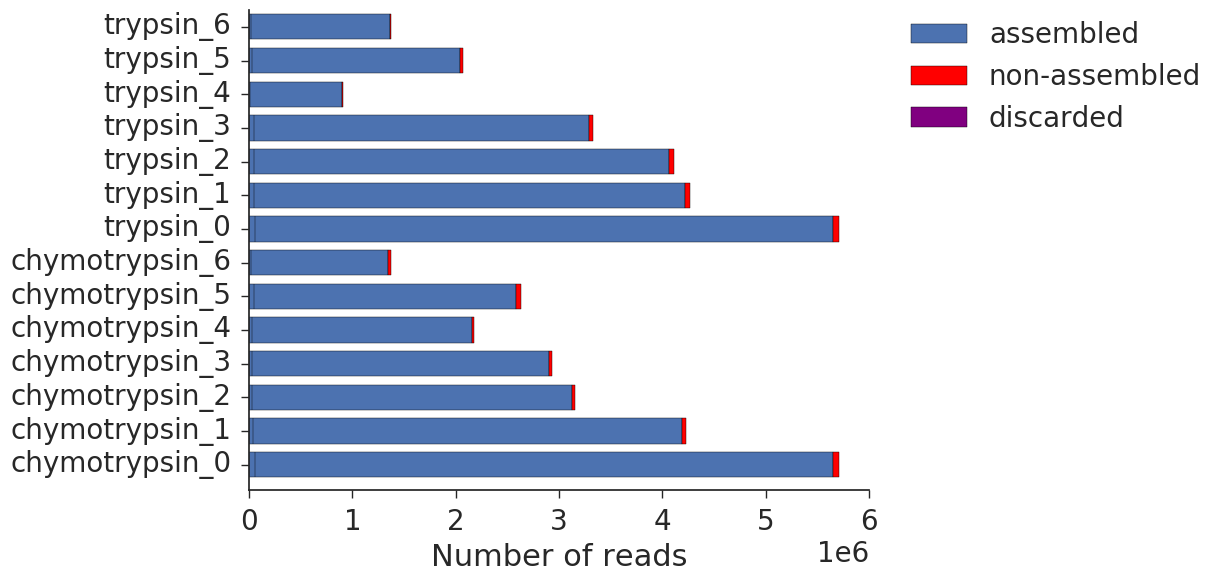

In [21]:
Image(os.path.join(output_dir, "deep_sequencing_depth_and_quality.png"), width=700)

### Analyze the quality of the EC50 estimates, filtering those with 95% credible intervals below 2 EC50 units.

Read in stability scores, EC50 values, etc. from the pipeline. Also read in design-specific topology information.

In [ ]:
# Read in stability scores, EC50 values, etc.
stability_scores_df = pandas.read_csv(merged_stability_scores_outfile, sep='\t')
stability_scores_df.set_index('name', inplace=True)

# Read in orignial design names to be able to merge data with the topologies file
naming_df = pandas.read_csv('data/180702_topology_mining/naming_key.csv')
naming_df.rename(columns={'name':'original_name', 'chip_name':'name'}, inplace=True)
naming_df['original_name'].replace('')
naming_df.set_index('name', inplace=True)
stability_scores_df = stability_scores_df.merge(naming_df, left_index=True, right_index=True, how='left')

# Read in topology-specific information and merge with dataframe for relevant designs
topology_df = pandas.read_csv(
    'data/180702_topology_mining/topology_mining_and_Longxing_chip_2.topologies.csv',
    comment='#'
)
topology_df.rename(columns={'name':'original_name'}, inplace=True)
stability_scores_df.reset_index(inplace=True)
stability_scores_df = stability_scores_df.merge(
    topology_df, left_on='original_name', right_on='original_name', how='left'
)
stability_scores_df.set_index('name', inplace=True)

Look at the distribution of 95% CIs.

In [ ]:
sns.kdeplot(stability_scores_df['ec50_95ci_c'], label='chymotrypsin', shade=True)
sns.kdeplot(stability_scores_df['ec50_95ci_t'], label='trypsin', shade=True)
sns.despine()
plt.ylabel("proportion of designs")
plt.xlabel("EC50 95% credible interval")
plt.xlim([-1, 4])
plt.show()

Filter out designs where the 95% CI is greater than some threshold (e.g., Gabe used a threshold of two EC50 units in his paper).

In [ ]:
# Find sequences where the EC50 CI is greater than a given cutoff
cutoff = 1
high_confidence_seqs_bools = \
    (stability_scores_df['ec50_95ci_t'] < cutoff) & \
    (stability_scores_df['ec50_95ci_c'] < cutoff)

# Make a list of stable sequences that passed the CI-based filtering step
print("The total number of sequences is: {0}".format(len(stability_scores_df)))
print("Filtering out sequences with EC50 95% CIs > {0}".format(cutoff))
print("The number of remaining sequences is: {0}".format(sum(high_confidence_seqs_bools)))

### Analyze the distribution of EC50 values and how the EC50 values for sequences in the ladder compare with EC50 values measured in Rocklin et al.

Look at the distribution of EC50 values.

In [ ]:
data = stability_scores_df[high_confidence_seqs_bools]
sns.kdeplot(data['ec50_t'], label='trypsin', shade=True)
sns.kdeplot(data['ec50_c'], label='chymotrypsin', shade=True)
plt.xlabel('EC50')
plt.ylabel('proportion of designs')
plt.legend()
sns.despine()
plt.show()

Compare EC50 values for sequences in the ladder with and without GSS padding

In [ ]:
# Read in ladder sequences and EC50 values from Rocklin et al.
ladder_df = pandas.read_csv('data/ladder/180705_ladder_sequences.csv')
ladder_df.set_index('chip_name', inplace=True)
ladder_df = ladder_df[ladder_df['library_name'] == 'Rocklin_2017_Science']
ladder_df.rename(columns={'ec50_t':'Rocklin\ntrypsin', 'ec50_c':'Rocklin\nchymotrypsin'}, inplace=True)

# Add EC50 values for ladder sequences from this study with GSS padding
ladder_df = ladder_df.merge(stability_scores_df[['ec50_c', 'ec50_t']], left_index=True, right_index=True, how='left')
ladder_df.rename(columns={'ec50_t':'current study\nwith padding\ntrypsin', 'ec50_c':'current study\nwith padding\nchymotrypsin'}, inplace=True)

# Add EC50 values for ladder sequences from this study without GSS padding
ladder_no_padding_df = stability_scores_df[
   stability_scores_df.apply(lambda row: '_no_padding' in row.name, axis=1) 
].copy()
ladder_no_padding_df['ladder_name'] = ladder_no_padding_df.apply(
    lambda row: row.name.replace('_no_padding', ''), axis=1
)
ladder_no_padding_df.set_index('ladder_name', inplace=True)
ladder_df = ladder_df.merge(ladder_no_padding_df[['ec50_c', 'ec50_t']], left_index=True, right_index=True, how='left')
ladder_df.rename(
    columns={'ec50_t':'current study\nno padding\ntrypsin', 'ec50_c':'current study\nno padding\nchymotrypsin'},
    inplace=True
)

# Make plots showing the correlation among different sets of sequences
proteases = ['trypsin', 'chymotrypsin']
for protease in proteases:
    print("Showing correlations for {0}".format(protease))
    columns_to_plot = [
        'Rocklin\n{0}'.format(protease),
        'current study\nwith padding\n{0}'.format(protease),
        'current study\nno padding\n{0}'.format(protease)
    ]
    g = sns.pairplot(ladder_df[columns_to_plot], size=3.5, kind='reg')

    range_min = -2
    range_max = 8
    ticks = list(range(range_min, range_max, 2))
    g.set(xticks=ticks, yticks=ticks, xlim=[range_min, range_max-1], ylim=[range_min, range_max-1])
    for ax in g.axes.flat:
        ax.plot([range_min, range_max], [range_min, range_max], c=".2", ls="--")
    
    # Add a correlation coefficient to the lower plots
    def corrfunc(x, y, **kws):
        r, _ = scipy.stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("R = {:.2f}".format(r),
                    xy=(.1, .9), xycoords=ax.transAxes)
    g.map_lower(corrfunc)
        
    plt.show()

### Analyze the distribution of stability scores for trypsin vs. chymotrypsin and for designs vs. negative controls

Plot the stability scores for different proteases

In [ ]:
data = stability_scores_df[high_confidence_seqs_bools]
sns.kdeplot(data['stabilityscore_t'], label='trypsin', shade=True)
sns.kdeplot(data['stabilityscore_c'], label='chymotrypsin', shade=True)
plt.xlabel('stability score')
plt.ylabel('proportion of designs')
plt.legend()
sns.despine()
plt.show()

Look at the correlation between the stability scores for trypsin and chymotrypsin.

In [ ]:
data = stability_scores_df[high_confidence_seqs_bools]
print(data['stabilityscore_t'].corr(data['stabilityscore_c']))
fig = plt.figure(figsize=(5,5))
sns.regplot(
    x='stabilityscore_c',
    y='stabilityscore_t',
    data=stability_scores_df,
    fit_reg=False,
    color='k',
    scatter_kws={'alpha':0.01, 's':50}
)

range_min = -2
range_max = 4
ticks = list(range(range_min, range_max))
plt.xlim([range_min, range_max-1])
plt.ylim([range_min, range_max-1])
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel('Chymotrypsin stability')
plt.ylabel('Trypsin stability')
#plt.axis('equal')
sns.despine()
plt.show()

### Analyze data from the designs made for the topology-mining project

To do:

* Analyze by size distribution, design strategy and designer (where are Craig's and Alex's designs?), topology

First, plot the distribution in stability scores

In [ ]:
# Make a dataframe of just the topology-mining designs
tm_df = stability_scores_df[
    stability_scores_df.apply(lambda row: 'tm' in row.name, axis=1) &
    ~stability_scores_df['stabilityscore'].isnull()
].copy()

# Identify negative controls
tm_df['negative_control'] = tm_df.apply(lambda row: 'ntm' in row.name, axis=1)

# Plot the distribution of stability scores for designs vs. scrambled negative controls
sns.kdeplot(tm_df[~tm_df['negative_control']]['stabilityscore'], label='designs', shade=True)
sns.kdeplot(tm_df[tm_df['negative_control']]['stabilityscore'], label='scrambled controls', shade=True)
plt.legend()
plt.xlabel('stability score')
plt.ylabel('fraction of designs')
sns.despine()
plt.show()

In [ ]:
sum(tm_df[~tm_df['negative_control']]['stabilityscore'] >= 1) / float(sum(~tm_df['negative_control']))
sum(tm_df[tm_df['negative_control']]['stabilityscore'] >= 1) / float(sum(tm_df['negative_control']))

tm_df['n_cys'] = tm_df['protein_sequence_c'].apply(lambda x: x.count('C'))
tm_df[
    tm_df['topology'] == '0a6b'
].sort_values(by='stabilityscore', ascending=False)[['original_name', 'stabilityscore', 'n_cys']]

Plot the distribution of protein stability for different topologies

In [ ]:
data = tm_df[
    (~tm_df['topology'].isnull()) &
    (~tm_df['stabilityscore'].isnull())
]
sns.boxplot(x='stabilityscore', y='topology', data=data)
sns.despine()

In [ ]:
stability_cutoff = 1.0
tm_df['stable'] = tm_df['stabilityscore'] >= stability_cutoff
data = tm_df[
    ~tm_df['topology'].isnull() &
    ~tm_df['stable'].isnull()
]
sns.countplot(y='topology', hue='stable', data=data)
sns.despine()

For designs with matched controls, plot the stability score of that design against the difference in stability score with the negative control

In [ ]:
def compute_stability_of_control(design_index):
    control_index = 'n' + design_index
    if control_index in tm_df.index.values:
        negative_control_stability = tm_df.loc[control_index]['stabilityscore']
        return negative_control_stability
    else:
        return None

# Compute differences in stability scores
tm_df['stability_of_control'] = tm_df.apply(
    lambda row: compute_stability_of_control(row.name), axis=1
)
tm_df['delta_stability'] = tm_df.apply(
    lambda row: row['stabilityscore'] - row['stability_of_control'], axis=1
)

# Plot differences vs. the design stability score
topologies = set(tm_df[~tm_df['topology'].isnull()]['topology'])
for topology in topologies:
    print(topology)
    data = tm_df[
        (~tm_df['delta_stability'].isnull()) &
        (tm_df['topology'] == topology)
    ]
    sns.jointplot(x='stabilityscore', y='delta_stability', data=data, stat_func=None)
    #plt.ylabel('delta stability\n(=design-control)')
    plt.show()

Plot the fraction of designs above a given stability score for designs and controls

In [ ]:
stability_range = np.arange(-2, 3, 0.1)

for topology in topologies:
    
    # Get a list of stability scores for designs and controls
    print(topology)
    data = tm_df[
        (~tm_df['negative_control']) &
        (~tm_df['stability_of_control'].isnull()) &
        (tm_df['topology'] == topology)
    ]
    design_data = data['stabilityscore']
    control_data = data['stability_of_control']
        
    # Compute the fraction of designs or controls above a given threshold
    # for a series of thresholds
    fraction_above_threshold_dict = {
        key : []
        for key in ['stability', 'fraction_designs_above_threshold', 'fraction_controls_above_threshold']
    }
    for threshold in stability_range:
        fraction_above_threshold_dict['stability'].append(threshold)
        fraction_above_threshold_dict['fraction_designs_above_threshold'].append(
            sum(design_data >= threshold) / float(len(design_data))
        )
        fraction_above_threshold_dict['fraction_controls_above_threshold'].append(
            sum(control_data >= threshold) / float(len(control_data))
        )
    fraction_above_threshold_df = pandas.DataFrame.from_dict(fraction_above_threshold_dict)
    sns.regplot(
        x='stability', y='fraction_designs_above_threshold', data=fraction_above_threshold_df,
        label='designs', fit_reg=False
    )
    sns.regplot(
        x='stability', y='fraction_controls_above_threshold', data=fraction_above_threshold_df,
        label='controls', fit_reg=False
    )
    sns.despine()
    plt.ylabel('fraction above X')
    plt.legend()
    plt.show()

## Analyze the old and new EC50 values for the ladder sequences

In [ ]:
# Read in ladder sequences and EC50 values from Rocklin et al.
ladder_df = pandas.read_csv('data/ladder/180705_ladder_sequences.csv')
ladder_df.set_index('chip_name', inplace=True)
ladder_df.rename(columns={'ec50_t':'original_trypsin', 'ec50_c':'original_chymotrypsin'}, inplace=True)

# Add EC50 values for ladder sequences from this study with GSS padding
ladder_df = ladder_df.merge(stability_scores_df[['ec50_c', 'ec50_t']], left_index=True, right_index=True, how='left')
ladder_df.rename(columns={'ec50_t':'trypsin_with_padding', 'ec50_c':'chymotrypsin_with_padding'}, inplace=True)

# Add EC50 values for ladder sequences from this study without GSS padding
ladder_no_padding_df = stability_scores_df[
   stability_scores_df.apply(lambda row: '_no_padding' in row.name, axis=1) 
].copy()
ladder_no_padding_df['ladder_name'] = ladder_no_padding_df.apply(
    lambda row: row.name.replace('_no_padding', ''), axis=1
)
ladder_no_padding_df.set_index('ladder_name', inplace=True)
ladder_df = ladder_df.merge(ladder_no_padding_df[['ec50_c', 'ec50_t']], left_index=True, right_index=True, how='left')
ladder_df.rename(
    columns={'ec50_t':'trypsin_without_padding', 'ec50_c':'chymotrypsin_without_padding'},
    inplace=True
)

In [ ]:
libraries

In [ ]:
libraries = list(set(ladder_df['library_name']))
for library in libraries:
    print("\nAnalyzing {0}".format(library))
    data = ladder_df[
        ladder_df['library_name'] == library
    ]
    fig, axs = plt.subplots(ncols=2, figsize=(10,4))
    sns.regplot(x='original_trypsin', y='trypsin_without_padding', data=data, ax=axs[0])
    sns.regplot(x='original_chymotrypsin', y='chymotrypsin_without_padding', data=data, ax=axs[1])
    min_range = -2
    max_range = 6
    axs[0].plot([min_range, max_range], [min_range, max_range], c='k', ls='--')
    axs[1].plot([min_range, max_range], [min_range, max_range], c='k', ls='--')
    ticks = list(range(min_range, max_range+1, 2))
    plt.setp(axs, xticks=ticks, yticks=ticks, xlim=[min_range, max_range], ylim=[min_range, max_range])
    sns.despine()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.show()